### Utilizando o arquivo CSV de microdados dos casos, construa um jupyter notebook para responder a essas perguntas:
https://www.saopaulo.sp.gov.br/planosp/simi/dados-abertos/

1. Existe diferença de incidência de covid entre homens e mulheres? 
2. Faça um gráfico da mortalidade por faixas de idade
3. Qual a doença pré-existente mais provável de se encontrar numa pessoa com covid?
4. Baseado nesses dados, faça um modelo que estime a probabilidade da pessoa morrer, uma vez que está contaminada com covid, e considerando os inputs de idade, gênero e doenças pré-existentes


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

#pd.set_option('display.float_format', '{:.8f}'.format)

#import missingno as msno

data_file='20230320_Casos_e_obitos_ESP.csv'

In [2]:
def read_file(file, nlines=5):
    '''
    Le as primeiras linhas de um arquivo texto
    file = path do arquivo
    nlines = quantidade de linhas
    Equivalente aos comandos:
    Windos : !powershell Get-Content file_sample.txt -Head 5
    Linux: head -n 5 file_sample.txt
    '''
    with open(file, encoding='utf8') as file:
        lines=file.readlines()[:nlines] 

    return(''.join(lines))



def get_df_stats(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Passado um dataframe, retorna dataframe com análise básica dos dados
    '''
    df_stat = pd.concat([
        df.dtypes,              # Tipo de Dados
        df.nunique(),           # Qtd valores únicos
        df.dtypes,              # temporario - apenas para alocar a coluna
        df.isnull().sum(),      # Qtd nulos
        df.isnull().mean()*100, # Percentual de Nulos
        (df==0.00).sum(),       # Qtd de registros iguais a 0
        (df==1.00).sum(),       # Qtd de registros iguais a 1
        (df==0.00).mean()*100,  # Pct de registros iguais a 0
        (df==1.00).mean()*100   # Pct de registros iguais a 1
    ], axis=1)
    df_stat.columns = [ 'Tipo', 'Qtd_Categorias', 'Valores', 'Qtd_Missing', '% Missing', 'Qtd_0', 'Qtd_1', '% 0', '% 1' ]

    df_stat['Valores'] = df_stat.apply(lambda c: sorted(df[c.name].dropna().unique()) if c['Qtd_Categorias'] <= 5 else 
                                              f'{df[c.name].min().strftime("%Y-%m-%d")} ... {df[c.name].max().strftime("%Y-%m-%d")}' if (c['Qtd_Categorias'] > 5 and str(c['Tipo']).startswith('date') ) else
                                              f'{df[c.name].min()} ... {df[c.name].max()}' if (c['Qtd_Categorias'] > 5 and (str(c['Tipo']).startswith('int') or str(c['Tipo']).startswith('float')) ) else
                                              '', axis=1)                                       


    return df_stat

## Data Prep

Checando cabeçalho e separador das primeiras linhas e carregando o conteúdo do arquivo

In [3]:
print(read_file(data_file, 5))

Asma;Cardiopatia;Data_Inicio_Sintomas;Diabetes;Diagnostico_Covid19;Doenca_Hematologica;Doenca_Hepatica;Doenca_Neurologica;Doenca Renal;Genero;Idade;Imunodepressao;Municipio;Obesidade;Obito;Outros_Fatores_De_Risco;Pneumopatia;Puérpera;Síndrome_De_Down
IGNORADO;IGNORADO;15/07/2022;IGNORADO;CONFIRMADO;IGNORADO;IGNORADO;IGNORADO;IGNORADO;MASCULINO;69.0;IGNORADO;ASSIS;IGNORADO;0;IGNORADO;IGNORADO;IGNORADO;IGNORADO
IGNORADO;IGNORADO;21/02/2021;IGNORADO;CONFIRMADO;IGNORADO;IGNORADO;IGNORADO;IGNORADO;FEMININO;60.0;IGNORADO;SÃO PAULO;IGNORADO;0;IGNORADO;IGNORADO;IGNORADO;IGNORADO
IGNORADO;IGNORADO;23/06/2021;IGNORADO;CONFIRMADO;IGNORADO;IGNORADO;IGNORADO;IGNORADO;MASCULINO;58.0;IGNORADO;ARARAQUARA;IGNORADO;0;IGNORADO;IGNORADO;IGNORADO;IGNORADO
IGNORADO;IGNORADO;03/02/2021;IGNORADO;CONFIRMADO;IGNORADO;IGNORADO;IGNORADO;IGNORADO;FEMININO;45.0;IGNORADO;SÃO PAULO;IGNORADO;0;IGNORADO;IGNORADO;IGNORADO;IGNORADO



In [4]:
df = pd.read_csv(data_file, sep=';', na_values='IGNORADO')
df_bkp = df # Backup para não precisar ler novamente o CSV
df.head()

,Asma,Cardiopatia,Data_Inicio_Sintomas,Diabetes,Diagnostico_Covid19,Doenca_Hematologica,Doenca_Hepatica,Doenca_Neurologica,Doenca Renal,Genero,Idade,Imunodepressao,Municipio,Obesidade,Obito,Outros_Fatores_De_Risco,Pneumopatia,Puérpera,Síndrome_De_Down
0,NaN,NaN,15/07/2022,NaN,CONFIRMADO,NaN,NaN,NaN,NaN,MASCULINO,69.0,NaN,ASSIS,NaN,0,NaN,NaN,NaN,NaN
1,NaN,NaN,21/02/2021,NaN,CONFIRMADO,NaN,NaN,NaN,NaN,FEMININO,60.0,NaN,SÃO PAULO,NaN,0,NaN,NaN,NaN,NaN
2,NaN,NaN,23/06/2021,NaN,CONFIRMADO,NaN,NaN,NaN,NaN,MASCULINO,58.0,NaN,ARARAQUARA,NaN,0,NaN,NaN,NaN,NaN
3,NaN,NaN,03/02/2021,NaN,CONFIRMADO,NaN,NaN,NaN,NaN,FEMININO,45.0,NaN,SÃO PAULO,NaN,0,NaN,NaN,NaN,NaN
4,NaN,NaN,23/02/2021,NaN,CONFIRMADO,NaN,NaN,NaN,NaN,FEMININO,42.0,NaN,SÃO PAULO,NaN,0,NaN,NaN,NaN,NaN


In [5]:
df = df_bkp # Para não precisar ler novamente o CSV
COL_DOENCAS_PRE = ['Asma', 'Cardiopatia', 'Diabetes', 'Doenca_Hematologica', 'Doenca_Hepatica', 
               'Doenca_Neurologica', 'Doenca Renal', 'Imunodepressao', 'Obesidade', 
               'Outros_Fatores_De_Risco', 'Pneumopatia', 'Puérpera', 'Síndrome_De_Down']


Checando algumas caracteristicas dos dados, como por exemplo
- Tipo de dados na coluna
- Quantidade de categorias distintas 
- Amostra das categorias ou Mínimo e Máximo para colunas numérias e datas
- Quantidade e percentual de valores nulos (missing)
- Quantidade e percentual de valores 0 e 1

In [6]:
stat = get_df_stats(df)
stat

,Tipo,Qtd_Categorias,Valores,Qtd_Missing,% Missing,Qtd_0,Qtd_1,% 0,% 1
Asma,object,2,"[NÃO, SIM]",6276299,96.458456,0,0,0.000000,0.000000
Cardiopatia,object,2,"[NÃO, SIM]",5946222,91.385607,0,0,0.000000,0.000000
Data_Inicio_Sintomas,object,1140,,223555,3.435746,0,0,0.000000,0.000000
Diabetes,object,2,"[NÃO, SIM]",6060148,93.136499,0,0,0.000000,0.000000
Diagnostico_Covid19,object,1,[CONFIRMADO],0,0.000000,0,0,0.000000,0.000000
Doenca_Hematologica,object,2,"[NÃO, SIM]",6279856,96.513122,0,0,0.000000,0.000000
Doenca_Hepatica,object,2,"[NÃO, SIM]",6280622,96.524895,0,0,0.000000,0.000000
Doenca_Neurologica,object,2,"[NÃO, SIM]",6273351,96.413149,0,0,0.000000,0.000000
Doenca Renal,object,2,"[NÃO, SIM]",6263687,96.264626,0,0,0.000000,0.000000
Genero,object,3,"[FEMININO, INDEFINIDO, MASCULINO]",10,0.000154,0,0,0.000000,0.000000


Corrigindo tipo Date

In [7]:
# Poderia ter forçado o tipo na leitura do dataframe com os parametros parse_dates=['Data_Inicio_Sintomas'], dayfirst=True
df['Data_Inicio_Sintomas'] = pd.to_datetime(df['Data_Inicio_Sintomas'], dayfirst=True)

Transformação de Valores
- SIM=1
- NÃO=0
- NA=-1

Teria o mesmo efeito usando os parâmetros abaixo na leitura do dataframe:<br>
```pd.read_csv(... , true_values=['SIM'], false_values=['NÃO'])```

**Obs:** Optei por substituir NA por -1 para poder alterar a coluna para o tipo int.<br>
Caso o tipo não seja substituido, tipo será reconhecido como float, fazendo com que o dataframe ocupe mais espaço em memória

In [8]:
def transformar_sim_nao(valor):
    if valor == 'SIM':
        return 1
    elif valor == 'NÃO':
        return 0
    else:
        return valor


# Convertemdo valores em todas as colunas populadas com SIM/NÃO
for c in df:
    # Verifica se as categorias existentes são exclusivamente SIM e NÃO
    if set(df[c].dropna().unique()) == {'NÃO', 'SIM'}:
        print(f'Transformando {c}')
        #df[c] = df[c].map(transformar_sim_nao).fillna(-1).astype('int8', errors='ignore') # mantém os NAs
        df[c] = df[c].map(transformar_sim_nao).astype('int8', errors='ignore') # mantém os NAs

Transformando Asma
Transformando Cardiopatia
Transformando Diabetes
Transformando Doenca_Hematologica
Transformando Doenca_Hepatica
Transformando Doenca_Neurologica
Transformando Doenca Renal
Transformando Imunodepressao
Transformando Obesidade
Transformando Outros_Fatores_De_Risco
Transformando Pneumopatia
Transformando Puérpera
Transformando Síndrome_De_Down


In [9]:
# No caso da coluna Diagnostico_Covid19, como originalmente esta 100% preenchida com o valor 'CONFIRMADO', é mais eficiente simplesmente usar:
df['Diagnostico_Covid19'] = 1
# Poderíamos até mesmo excluir a coluna, já que não agrega nenhum valor e ocupa espaço desnecessário em memória

# Mesma transformação usando lambda Func:
# df['Diagnostico_Covid19'] = df.apply(lambda row: 1 if(row['Diagnostico_Covid19'])=='CONFIRMADO' else row['Diagnostico_Covid19'], axis=1)

In [10]:
df.head()

,Asma,Cardiopatia,Data_Inicio_Sintomas,Diabetes,Diagnostico_Covid19,Doenca_Hematologica,Doenca_Hepatica,Doenca_Neurologica,Doenca Renal,Genero,Idade,Imunodepressao,Municipio,Obesidade,Obito,Outros_Fatores_De_Risco,Pneumopatia,Puérpera,Síndrome_De_Down
0,NaN,NaN,2022-07-15,NaN,1,NaN,NaN,NaN,NaN,MASCULINO,69.0,NaN,ASSIS,NaN,0,NaN,NaN,NaN,NaN
1,NaN,NaN,2021-02-21,NaN,1,NaN,NaN,NaN,NaN,FEMININO,60.0,NaN,SÃO PAULO,NaN,0,NaN,NaN,NaN,NaN
2,NaN,NaN,2021-06-23,NaN,1,NaN,NaN,NaN,NaN,MASCULINO,58.0,NaN,ARARAQUARA,NaN,0,NaN,NaN,NaN,NaN
3,NaN,NaN,2021-02-03,NaN,1,NaN,NaN,NaN,NaN,FEMININO,45.0,NaN,SÃO PAULO,NaN,0,NaN,NaN,NaN,NaN
4,NaN,NaN,2021-02-23,NaN,1,NaN,NaN,NaN,NaN,FEMININO,42.0,NaN,SÃO PAULO,NaN,0,NaN,NaN,NaN,NaN


Checando dataframe novamente

In [11]:
stat = get_df_stats(df)
stat

,Tipo,Qtd_Categorias,Valores,Qtd_Missing,% Missing,Qtd_0,Qtd_1,% 0,% 1
Asma,float64,2,"[0.0, 1.0]",6276299,96.458456,214543,15896,3.297244,0.244301
Cardiopatia,float64,2,"[0.0, 1.0]",5946222,91.385607,99694,460822,1.532166,7.082228
Data_Inicio_Sintomas,datetime64[ns],1140,2020-02-04 ... 2023-03-19,223555,3.435746,0,0,0.000000,0.000000
Diabetes,float64,2,"[0.0, 1.0]",6060148,93.136499,139987,306603,2.151416,4.712085
Diagnostico_Covid19,int64,1,[1],0,0.000000,0,6506738,0.000000,100.000000
Doenca_Hematologica,float64,2,"[0.0, 1.0]",6279856,96.513122,222457,4425,3.418871,0.068006
Doenca_Hepatica,float64,2,"[0.0, 1.0]",6280622,96.524895,221490,4626,3.404010,0.071096
Doenca_Neurologica,float64,2,"[0.0, 1.0]",6273351,96.413149,210035,23352,3.227962,0.358890
Doenca Renal,float64,2,"[0.0, 1.0]",6263687,96.264626,211531,31520,3.250953,0.484421
Genero,object,3,"[FEMININO, INDEFINIDO, MASCULINO]",10,0.000154,0,0,0.000000,0.000000


## Data Cleaning

In [12]:
df_bkp_prep = df # guardando bkp do dataframe após trandormações

In [13]:
df = df_bkp_prep

#### Verificando Genero

In [14]:
pd.DataFrame({
     'Total': df['Genero'].fillna('NA').value_counts(),
     '%': df['Genero'].fillna('NA').value_counts() / len(df) * 100
})

,Total,%
FEMININO,3553298,54.609514
MASCULINO,2949959,45.336988
INDEFINIDO,3471,0.053345
NA,10,0.000154


In [15]:
df.query('Genero == "INDEFINIDO" or Genero.isna()')['Obito'].value_counts()

0    3481
Name: Obito, dtype: int64

A princípio a variável <b>Genero</b> com o dados <b><i>nulos</i></b> ou <b><i>INDEFINIDO</i></b> não trazem nenhuma diferenciação na contagem de Obitos, já que são todos iguais a 0.
Dessa forma, a criação de uma categoria para representar esses valores poderia enviesar o modelo.
Além disso, como a incidência desses valores é muito baixa, resolvi excluir essas linhas.

In [16]:
df = df.query('Genero != "INDEFINIDO" and Genero.notna()')

pd.DataFrame({
     'Total': df['Genero'].fillna('NA').value_counts(),
     '%': df['Genero'].fillna('NA').value_counts() / len(df) * 100
})

,Total,%
FEMININO,3553298,54.638745
MASCULINO,2949959,45.361255


#### Verificando Idade

Estimando limite superior de corte de Idade a partir mediana + 4 desvios

In [17]:
limite_idade = df['Idade'].median() + (4 * df['Idade'].std())
print('Idade limite de corte considerando 4 desvios: {:.1f}'.format(limite_idade))

Idade limite de corte considerando 4 desvios: 113.6


Visualizando boxplot de Idade

<AxesSubplot:xlabel='Idade'>

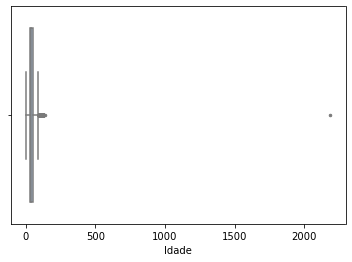

In [18]:
#sns.boxenplot(x=df['Idade'])
sns.boxplot( data=df, x="Idade", flierprops={"marker": "."}, palette='pastel')

Verificando frequência de idades acima da faixa de corte

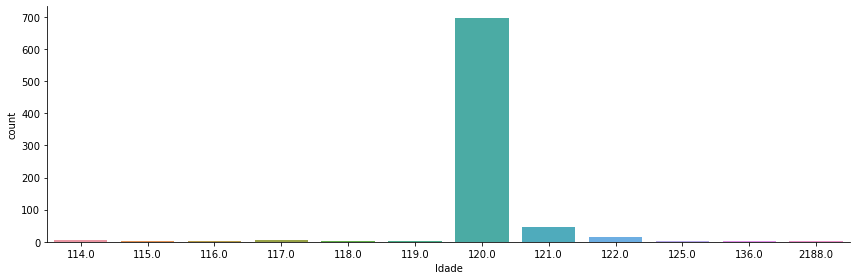

In [19]:
sns.catplot(x='Idade', kind='count', data=df.query(f'Idade > {limite_idade}'), height=4, aspect=3/1)

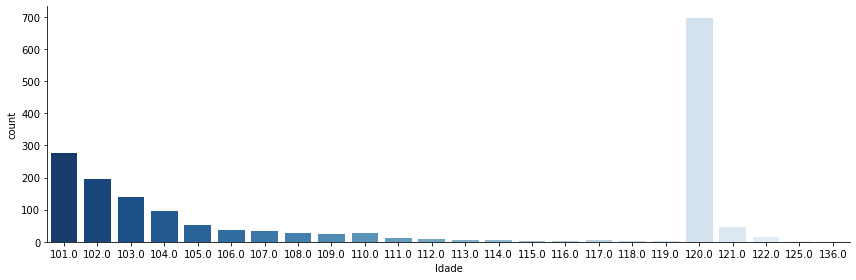

In [20]:
sns.catplot(x='Idade', kind='count', data=df.query('Idade > 100 & Idade < 150'), height=4, aspect=3/1, palette='Blues_r')

Observando os gráficos acima, podemos perceber que existe uma grande concentração de ocorrências de Idade=120.<br>
Essa grande quantidade de ocorrências pode representar algum problema nos dados.<br>
O valor 120 esta acima da faixa de corte calculada, e destoa da curva de distribuição normal, além de estar significativamente acima da expectativa de vida atual de aproximadamente 80 anos, segundo relatório do [IBGE](https://www.ibge.gov.br/novo-portal-destaques.html?destaque=35600).<br><br>
Desta forma, decidi fazer a exclusão dos registros com idade >= 120 e observar novamente a distribuição

In [21]:
df = df.query('Idade < 120')

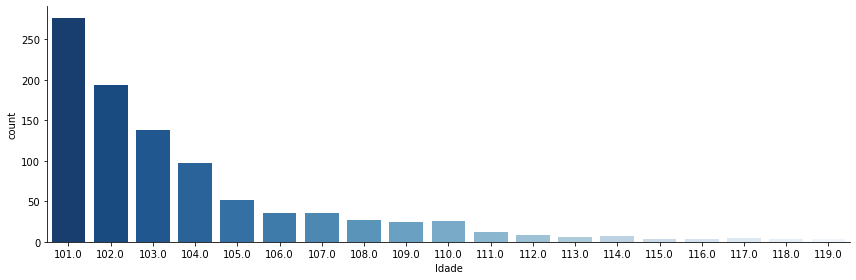

In [22]:
#sns.catplot(x='Genero', hue='Obito', kind='count', data=df)
sns.catplot(x='Idade', kind='count', data=df.query('Idade > 100'), height=4, aspect=3/1, palette='Blues_r')

In [23]:
df.query(f'Idade > {limite_idade}')['Idade'].value_counts()

114.0    7
117.0    5
118.0    4
116.0    3
119.0    3
115.0    3
Name: Idade, dtype: int64

Como são pouquíssimos registros que ficaram com a Idade acima do limite de corte calculado, e parecem estar alinhados com uma distribuição normal, resolvi não utilizar o corte calculado e manter esses registros.

In [24]:
stat = get_df_stats(df)
stat

,Tipo,Qtd_Categorias,Valores,Qtd_Missing,% Missing,Qtd_0,Qtd_1,% 0,% 1
Asma,float64,2,"[0.0, 1.0]",6072638,96.344024,214543,15896,3.403782,0.252194
Cardiopatia,float64,2,"[0.0, 1.0]",5745186,91.148910,99694,458197,1.581672,7.269418
Data_Inicio_Sintomas,datetime64[ns],1140,2020-02-04 ... 2023-03-19,27634,0.438421,0,0,0.000000,0.000000
Diabetes,float64,2,"[0.0, 1.0]",5858797,92.951379,139987,304293,2.220931,4.827690
Diagnostico_Covid19,int64,1,[1],0,0.000000,0,6303077,0.000000,100.000000
Doenca_Hematologica,float64,2,"[0.0, 1.0]",6076195,96.400456,222457,4425,3.529340,0.070204
Doenca_Hepatica,float64,2,"[0.0, 1.0]",6076961,96.412609,221490,4626,3.513998,0.073393
Doenca_Neurologica,float64,2,"[0.0, 1.0]",6069690,96.297253,210035,23352,3.332261,0.370486
Doenca Renal,float64,2,"[0.0, 1.0]",6060287,96.148072,211531,31259,3.355996,0.495932
Genero,object,2,"[FEMININO, MASCULINO]",0,0.000000,0,0,0.000000,0.000000


# Analisando os dados

### 1. Existe diferença de incidência de covid entre homens e mulheres? <a id='question_01'></a>

In [25]:
df_plot = pd.DataFrame({
    '% Total': df['Genero'].value_counts(normalize=True)*100,
    '% com Óbito': df.query('Obito==1')['Genero'].value_counts(normalize=True)*100
})
df_plot

,% Total,% com Óbito
FEMININO,54.678152,43.750314
MASCULINO,45.321848,56.249686


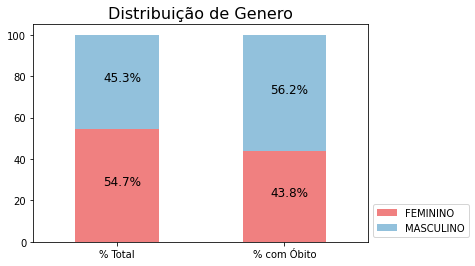

In [26]:
ax = df_plot.T.plot(kind='bar', stacked=True, color=['#f08080', '#92c1dc'])

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    x = p.get_x() + p.get_width()/3 
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y), size = 12)

plt.title('Distribuição de Genero', fontsize=16)
plt.legend(loc='lower left', bbox_to_anchor=(1,0))
plt.xticks(rotation=0)
plt.show()

In [27]:
#df.groupby('Genero')['Obito'].value_counts(normalize=True)
df_plot = df[['Genero', 'Obito']].groupby(['Genero']).mean().mul(100).reset_index()
df_plot

,Genero,Obito
0,FEMININO,2.276081
1,MASCULINO,3.530473


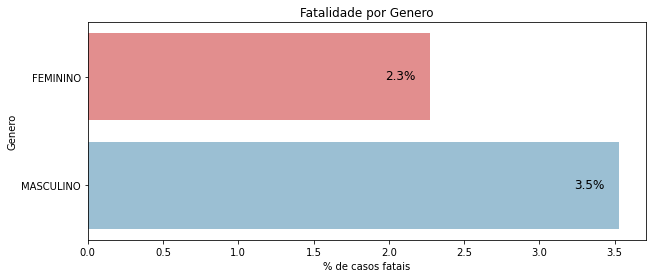

In [28]:
pal = dict(MASCULINO="#92c1dc", FEMININO="#f08080")

ax = sns.barplot(x='Obito', y='Genero', data=df_plot, palette=pal)
ax.set_xlabel('% de casos fatais')
ax.set_title('Fatalidade por Genero')
ax.figure.set_size_inches(10,4)


for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_width())
    x = p.get_x() + p.get_width() - 0.3
    y = p.get_y() + p.get_height()/1.9
    ax.annotate(percentage, (x, y), size = 12)
plt.show()


Utilizando os dados fornecidos concluímos que dentro dessa amostra, 54.7% dos casos são de mulheres e 45.3% são homens. Já entre os Óbitos temos 43.7% de mulheres e 56.3% de homens. Quando comparamos as fatalidades entre o mesmo genero, vemos que, entre as mulheres 2,3% dos casos foram fatais contra 3.5% de casos fatais entre os homens.
Com esses dados, podemos inferir que os homens parecem ser mais propensos ao óbito do que as mulheres. Porém, <b>não temos informações suficientes</b> para afirmar que as mulheres são mais infectadas pelo covido do que os homens.<br>

Alguns pontos levados em consideração:
- Para podemos comparar qual genero é mais propenso à infecção, precisaríamos ter na base os casos não infectados, e assim calcular Genero Infectadas/Total de pessoas do Genero.
- Segundo dados obtidos no site do [SEADE](https://populacao.seade.gov.br/), a população atual em SP está dividida em 51.3% de mulheres e 48.7% de homens. Dessa forma, a incidência de covid em mulheres ser de 54.7%, pode ser apenas um reflexo da população<br>
- Outro hipótese importante é que as mulheres tendem a procuram mais atendimento médico do que os homens<br>

### 2. Faça um gráfico da mortalidade por faixas de idade

In [29]:
age_bins = [i*5 for i in range(int(100//5))] + [120]

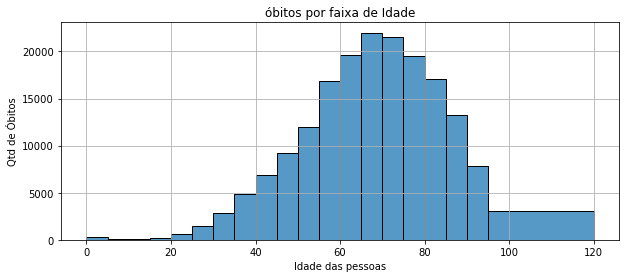

In [30]:
ax = sns.histplot(x='Idade', data=df.query('Obito==1'), stat='count', bins=age_bins)
ax.set_xlabel('Idade das pessoas')
ax.set_ylabel('Qtd de Óbitos')
ax.grid()
ax.set_title('óbitos por faixa de Idade')
ax.figure.set_size_inches(10,4)

In [31]:
df['Idade_Rng'] = pd.cut(df['Idade'], bins=age_bins)
df_plot = df[['Idade_Rng', 'Obito']].groupby(['Idade_Rng'], as_index=False).mean().sort_values(by='Idade_Rng', ascending=True)
df_plot['Obito'] = df_plot['Obito']*100
df_plot

,Idade_Rng,Obito
0,"(0, 5]",0.103461
1,"(5, 10]",0.048115
2,"(10, 15]",0.058378
3,"(15, 20]",0.077770
4,"(20, 25]",0.148349
5,"(25, 30]",0.278741
6,"(30, 35]",0.469332
7,"(35, 40]",0.747684
8,"(40, 45]",1.180936
9,"(45, 50]",1.774630


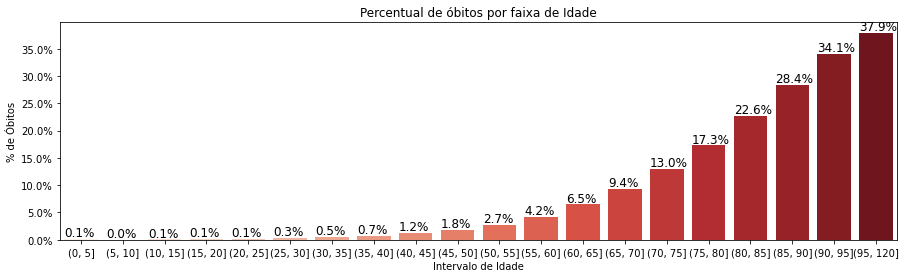

In [32]:
ax = sns.barplot(x='Idade_Rng', y='Obito', data=df_plot, palette='Reds')
ax.set_xlabel('Intervalo de Idade')
ax.set_ylabel('% de Óbitos')
ax.set_title('Percentual de óbitos por faixa de Idade')
ax.figure.set_size_inches(15,4)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    x = p.get_x() + p.get_width() - 0.8
    y = p.get_y() + p.get_height() + 0.5
    ax.annotate(percentage, (x, y), size = 12)
plt.show()

### 3. Qual a doença pré-existente mais provável de se encontrar numa pessoa com covid?

In [33]:
df_plot = pd.DataFrame(((df[COL_DOENCAS_PRE]==1).mean()*100) ).sort_values(by=[0], ascending=False)
df_plot.columns=['%']
df_plot

,%
Cardiopatia,7.269418
Diabetes,4.827690
Outros_Fatores_De_Risco,2.391721
Obesidade,0.767308
Imunodepressao,0.593964
Doenca Renal,0.495932
Doenca_Neurologica,0.370486
Pneumopatia,0.312324
Asma,0.252194
Doenca_Hepatica,0.073393


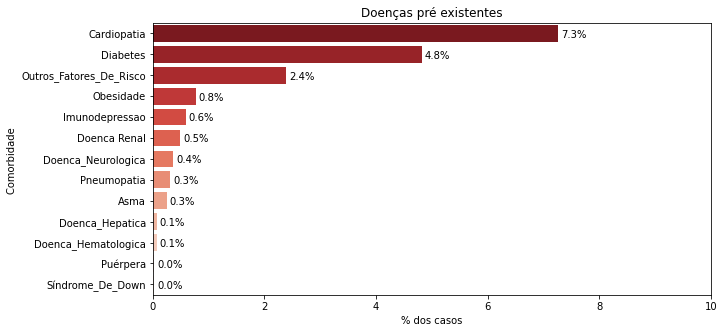

In [34]:
ax = sns.barplot(x='%', y=df_plot.index, data=df_plot, palette='Reds_r')

ax.set_title('Doenças pré existentes')
ax.set_xlabel('% dos casos')
ax.set_ylabel('Comorbidade ')
ax.figure.set_size_inches(10,5)

ax.set(xlim=(0, 10))

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_width())
    x = p.get_x() + p.get_width() + 0.05
    y = p.get_y() + p.get_height() - 0.2
    ax.annotate(percentage, (x, y), size = 10)
plt.show()


Desconsiderando os registros sem resposta

In [35]:
df_tmp = pd.DataFrame({
    'Não':(df[COL_DOENCAS_PRE]==0).sum(),
    'Sim': (df[COL_DOENCAS_PRE]==1).sum(),
    'Total': (df[COL_DOENCAS_PRE]>=0).sum()
})

df_tmp['%'] = df_tmp['Sim']/df_tmp['Total']*100

df_plot = df_tmp.sort_values(by='%', ascending=False)
df_plot


,Não,Sim,Total,%
Cardiopatia,99694,458197,557891,82.130201
Diabetes,139987,304293,444280,68.491267
Outros_Fatores_De_Risco,125183,150752,275935,54.633156
Obesidade,189053,48364,237417,20.370909
Imunodepressao,215087,37438,252525,14.825463
Doenca Renal,211531,31259,242790,12.874912
Doenca_Neurologica,210035,23352,233387,10.005699
Pneumopatia,213018,19686,232704,8.459674
Asma,214543,15896,230439,6.898138
Doenca_Hepatica,221490,4626,226116,2.045853


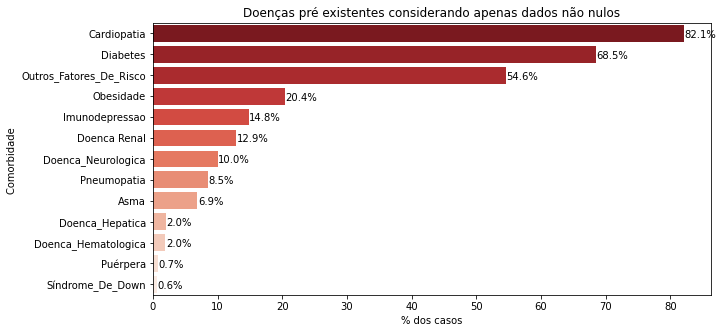

In [36]:
ax = sns.barplot(x='%', y=df_plot.index, data=df_plot, palette='Reds_r')

ax.set_title('Doenças pré existentes considerando apenas dados não nulos')
ax.set_xlabel('% dos casos')
ax.set_ylabel('Comorbidade ')
ax.figure.set_size_inches(10,5)

#ax.set(xlim=(0, 10))

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_width())
    x = p.get_x() + p.get_width() + 0.05
    y = p.get_y() + p.get_height() - 0.2
    ax.annotate(percentage, (x, y), size = 10)
plt.show()


Percentual das Doenças pré existentes entre os casos fatais

In [37]:
df_plot = pd.DataFrame(((df.query('Obito==1')[COL_DOENCAS_PRE]==1).mean()*100) ).sort_values(by=[0], ascending=False)
df_plot.columns=['%']
df_plot

,%
Cardiopatia,42.275108
Outros_Fatores_De_Risco,30.422149
Diabetes,30.038428
Obesidade,9.618120
Doenca_Neurologica,6.140092
Doenca Renal,5.660440
Pneumopatia,5.031317
Imunodepressao,3.401061
Asma,2.171258
Doenca_Hepatica,1.228130


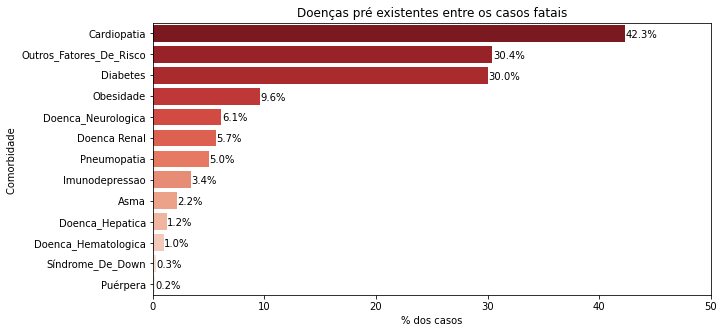

In [38]:
ax = sns.barplot(x='%', y=df_plot.index, data=df_plot, palette='Reds_r')

ax.set_title('Doenças pré existentes entre os casos fatais')
ax.set_xlabel('% dos casos')
ax.set_ylabel('Comorbidade ')
ax.figure.set_size_inches(10,5)

ax.set(xlim=(0, 50))

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_width())
    x = p.get_x() + p.get_width() + 0.05
    y = p.get_y() + p.get_height() - 0.2
    ax.annotate(percentage, (x, y), size = 10)
plt.show()

Portanto, podemos afirmar que a Cardiopatia é a doença pré existente mais frequente atingindo 7.3% dos casos confirmados de covid e presente em 43.3% dos casos fatais. Diabetes e Outros fatores de Risco, ficam em 2º e 3º lugar.

### 4. Baseado nesses dados, faça um modelo que estime a probabilidade da pessoa morrer, uma vez que está contaminada com covid, e considerando os inputs de idade, gênero e doenças pré-existentes

In [39]:
df_bkp = df

In [110]:
df = df_bkp
get_df_stats(df)

,Tipo,Qtd_Categorias,Valores,Qtd_Missing,% Missing,Qtd_0,Qtd_1,% 0,% 1
Asma,float64,2,"[0.0, 1.0]",6072638,96.344024,214543,15896,3.403782,0.252194
Cardiopatia,float64,2,"[0.0, 1.0]",5745186,91.148910,99694,458197,1.581672,7.269418
Data_Inicio_Sintomas,datetime64[ns],1140,2020-02-04 ... 2023-03-19,27634,0.438421,0,0,0.000000,0.000000
Diabetes,float64,2,"[0.0, 1.0]",5858797,92.951379,139987,304293,2.220931,4.827690
Diagnostico_Covid19,int64,1,[1],0,0.000000,0,6303077,0.000000,100.000000
Doenca_Hematologica,float64,2,"[0.0, 1.0]",6076195,96.400456,222457,4425,3.529340,0.070204
Doenca_Hepatica,float64,2,"[0.0, 1.0]",6076961,96.412609,221490,4626,3.513998,0.073393
Doenca_Neurologica,float64,2,"[0.0, 1.0]",6069690,96.297253,210035,23352,3.332261,0.370486
Doenca Renal,float64,2,"[0.0, 1.0]",6060287,96.148072,211531,31259,3.355996,0.495932
Genero,object,2,"[FEMININO, MASCULINO]",0,0.000000,0,0,0.000000,0.000000


Removendo as linhas onde todas as doenças são nulas. O intuito é limpar os registros onde não há nenhuma informação precisa sobre as doenças

In [111]:
df =  df[~(df[COL_DOENCAS_PRE].isna()).all(axis=1)]

Criando dummies para Genero e removendo colunas desnecessárias

In [112]:
df = pd.concat([df, pd.get_dummies(df['Genero'])], axis=1)

COLS = ['Obito', 'Idade', 'FEMININO', 'MASCULINO'] + COL_DOENCAS_PRE
df = df[COLS]
get_df_stats(df)

,Tipo,Qtd_Categorias,Valores,Qtd_Missing,% Missing,Qtd_0,Qtd_1,% 0,% 1
Obito,int64,2,"[0, 1]",0,0.000000,627910,131029,82.735240,17.264760
Idade,float64,114,0.0 ... 114.0,0,0.000000,1380,521,0.181833,0.068648
FEMININO,uint8,2,"[0, 1]",0,0.000000,353471,405468,46.574362,53.425638
MASCULINO,uint8,2,"[0, 1]",0,0.000000,405468,353471,53.425638,46.574362
Asma,float64,2,"[0.0, 1.0]",528500,69.636690,214543,15896,28.268807,2.094503
Cardiopatia,float64,2,"[0.0, 1.0]",201048,26.490667,99694,458197,13.135970,60.373363
Diabetes,float64,2,"[0.0, 1.0]",314659,41.460381,139987,304293,18.445092,40.094527
Doenca_Hematologica,float64,2,"[0.0, 1.0]",532057,70.105371,222457,4425,29.311578,0.583051
Doenca_Hepatica,float64,2,"[0.0, 1.0]",532823,70.206301,221490,4626,29.184164,0.609535
Doenca_Neurologica,float64,2,"[0.0, 1.0]",525552,69.248253,210035,23352,27.674820,3.076927


In [113]:
get_df_stats(df.query('Obito==1'))


,Tipo,Qtd_Categorias,Valores,Qtd_Missing,% Missing,Qtd_0,Qtd_1,% 0,% 1
Obito,int64,1,[1],0,0.000000,0,131029,0.000000,100.000000
Idade,float64,113,0.0 ... 114.0,0,0.000000,83,18,0.063345,0.013737
FEMININO,uint8,2,"[0, 1]",0,0.000000,71440,59589,54.522281,45.477719
MASCULINO,uint8,2,"[0, 1]",0,0.000000,59589,71440,45.477719,54.522281
Asma,float64,2,"[0.0, 1.0]",48784,37.231453,78352,3893,59.797449,2.971098
Cardiopatia,float64,2,"[0.0, 1.0]",22586,17.237405,32645,75798,24.914332,57.848263
Diabetes,float64,2,"[0.0, 1.0]",29539,22.543864,47632,53858,36.352258,41.103878
Doenca_Hematologica,float64,2,"[0.0, 1.0]",49081,37.458120,80198,1750,61.206298,1.335582
Doenca_Hepatica,float64,2,"[0.0, 1.0]",49216,37.561151,79611,2202,60.758305,1.680544
Doenca_Neurologica,float64,2,"[0.0, 1.0]",46106,35.187630,73914,11009,56.410413,8.401957


In [114]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import xgboost as xgb
from xgboost import XGBClassifier

Distribuição % de obitos

In [115]:
print(df['Obito'].value_counts(normalize=True))

0    0.827352
1    0.172648
Name: Obito, dtype: float64


In [116]:
X = df.drop(["Obito"], axis=1)
y = df["Obito"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [117]:
model = XGBClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)


score = model.score(X_test, y_test)
#print("Acurácia do modelo: {:.2f}", score)
print("Acurácia: %.2f%%" % (score * 100.0))
print(classification_report(y_test, y_pred))

Acurácia: 83.46%
              precision    recall  f1-score   support

           0       0.86      0.96      0.91    125670
           1       0.55      0.22      0.31     26118

    accuracy                           0.83    151788
   macro avg       0.70      0.59      0.61    151788
weighted avg       0.80      0.83      0.80    151788



Confusion matrix:
 [[120940   4730]
 [ 20379   5739]]


C:\Users\U009262\AppData\Local\Temp/ipykernel_26072/3478701259.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\U009262\AppData\Local\Temp/ipykernel_26072/3478701259.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


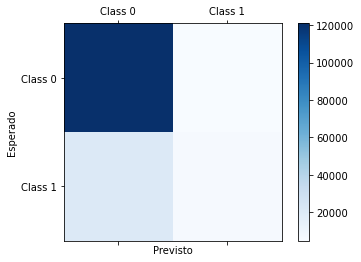

In [118]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Previsto')
plt.ylabel('Esperado')
plt.show()


Não podemos considerar a acurária de 83.4% como um bom resultado nesse caso, já que, caso o modelo tivesse previsto 0 para todos os casos, teria uma acurária de 82.7%, devido a concentração de obito=0 na base.<br>
Podemos comprovar isso observando os números apresentados em Precision (0.55), Recal (0.22) e F1 Score (0.31) para a classe 1.
Podemos rebalancear o dataframe usando o undersample da classe onde há maior concentração

In [119]:
df = pd.concat([
    df.query('Obito==0').sample(n=10000, random_state=42),
    df.query('Obito==1').sample(n=10000, random_state=42)
])

get_df_stats(df)


,Tipo,Qtd_Categorias,Valores,Qtd_Missing,% Missing,Qtd_0,Qtd_1,% 0,% 1
Obito,int64,2,"[0, 1]",0,0.000,10000,10000,50.000,50.000
Idade,float64,106,0.0 ... 106.0,0,0.000,26,6,0.130,0.030
FEMININO,uint8,2,"[0, 1]",0,0.000,9855,10145,49.275,50.725
MASCULINO,uint8,2,"[0, 1]",0,0.000,10145,9855,50.725,49.275
Asma,float64,2,"[0.0, 1.0]",11430,57.150,8103,467,40.515,2.335
Cardiopatia,float64,2,"[0.0, 1.0]",4495,22.475,3568,11937,17.840,59.685
Diabetes,float64,2,"[0.0, 1.0]",6857,34.285,5059,8084,25.295,40.420
Doenca_Hematologica,float64,2,"[0.0, 1.0]",11499,57.495,8340,161,41.700,0.805
Doenca_Hepatica,float64,2,"[0.0, 1.0]",11514,57.570,8284,202,41.420,1.010
Doenca_Neurologica,float64,2,"[0.0, 1.0]",11233,56.165,7768,999,38.840,4.995


In [120]:
X = df.drop(["Obito"], axis=1)
y = df["Obito"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [121]:
model = XGBClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)


score = model.score(X_test, y_test)
#print("Acurácia do modelo: {:.2f}", score)
print("Acurácia: %.2f%%" % (score * 100.0))
print(classification_report(y_test, y_pred))

Acurácia: 76.92%
              precision    recall  f1-score   support

           0       0.81      0.71      0.76      2019
           1       0.74      0.83      0.78      1981

    accuracy                           0.77      4000
   macro avg       0.77      0.77      0.77      4000
weighted avg       0.77      0.77      0.77      4000



Confusion matrix:
 [[1431  588]
 [ 335 1646]]


C:\Users\U009262\AppData\Local\Temp/ipykernel_26072/3478701259.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
C:\Users\U009262\AppData\Local\Temp/ipykernel_26072/3478701259.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


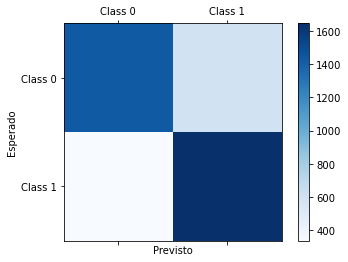

In [122]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Previsto')
plt.ylabel('Esperado')
plt.show()


Após o rebalanceamento da base, apesar da acurácia ter caído de 83% para 77%, o modelo se mostrou mais robusto.
As métricas de Precision, Recall e f1 Score se mostraram mais equilibradas para ambas as classes, o que indica que o modelo na seguna versão é mais confiável.